# Deep Learning for Art Generation
In this notebook we will use the methods outlined by Gatys et al. in their [paper](https://arxiv.org/abs/1508.06576) to produce a picture of the Oosterpark in Amsterdam in Van Gogh style. This project was carried out as part of the Deep Learning specialization from deeplearning.ai by Andrew Ng: the helper functions and general idea were outlined in this course.

## General overview
We are going to employ Neural Style Transfer (NST) to merges two images: a content image (C) and a style image (S) in order to create a generated image (G). The generated image G combines the content of the image C with the style of image S.

As Gatys et al. mention in their paper, we are going to use a Deep Neural Network based on the VGG-Network developed by Simonyan and Zisserman in the paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556). The VGG model almost performs as good as humans in classifying images and the model is publicly [available](http://www.vlfeat.org/matconvnet/pretrained/) (see also the license). This has the big advantage that we don't have to train the model first (which potentially takes days on my CPU) since we already have pre-trained weights. We create a network in TensorFlow based on the first 16 layers of the VGG model - we are not going to use the last 3 fully connected layers.

The structure of the notebook is as follows:
1. Load the necessary libraries 
2. Load the pre-trained weights
3. Load the content and style images
4. Build the graph in TensorFlow:
    - Calculate content cost
    - Calculate style cost
    - Calculate total cost
    - Define optimizer and learning rate
5. Initialize the graph and run it for a large amount of iterations (100-200).

## Setup
Let's load in the necessary libraries, helper functions (from `nst_utils.py`) and pre-trained weights. The latter may take a while.

In [1]:
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import imageio
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

from nst_utils import *

%matplotlib inline

In [4]:
# The weights are in a Matlab-matrix, so under the hood we use a scipy method to load in the matrix.
# Then the weights are used to build the graph in TensorFlow.
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable_1:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 

Using the `assign()` function in TensorFlow we can pass an image through the graph. Next, we load in the content image (a picture of the Oosterpark) and the style image (a Van Gogh painting).

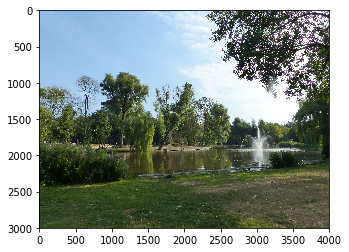

In [9]:
content_image = imageio.imread("Oosterpark.jpg")
imshow(content_image)

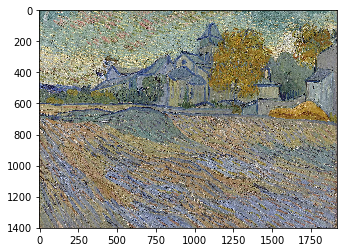

In [14]:
style_image = imageio.imread("VanGogh_Church.jpeg")
imshow(style_image)

## Cost function
Allright, let's compute the cost function: it consists of content cost and style cost. We will start with calculating the content cost. 

### Content cost function
We would like to have our generated image G a content which is similar to C, the content image. We are going to use the activations of a layer in the VGG-network to do this.

Suppose we take a hidden layer $l$ in the middle of the network (you can experiment by taking a different layer). Feed the image C in the VGG-network and let $a^{(C)} = a^{[l](C)}$ be the activations corresponding to the layer $l$. Then $a^{(C)}$ will be a $n_H \times n_W \times n_C$ tensor, where $n_H, n_W, n_C$ are the height, width and number of channels of the hidden layer $l$. Similarly, for the generated image $G$: let $a^{(G)} = a^{[l](G)}$ be the activations of the hidden layer $l$ when $G$ is feeded into the VGG-network. We define the content cost function $J_{\text{content}}$ as
\begin{equation} \label{content-cost} J_{\text{content}}(C,G) = \frac{1}{4 \times n_H \times n_W \times n_C} \sum_{\text{all entries}} (a^{(C)} - a^{(G)})^2.\end{equation}

Ok, let's now calculate the content cost function in TensorFlow by unrolling the 3D-tensors into 2D-matrices.

In [16]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that is computed using the equation above
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(tf.transpose(a_C),shape = [n_C,-1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G),shape = [n_C,-1])
    
    # compute the cost as above
    J_content = (1/(4 *n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
    
    return J_content

### Style cost function
Calculating the style cost is somewhat more involved because we need a measure for style first. We are going to calculate a so called Gram matrix at a given layer which  measures the correlation between the different filters of that particular layer. Later on we will average over different layers to obtain better results.

First, let's elaborate a bit more on the Gram matrix. Consider a set of vectors $\{v_1, \ldots, v_n\}$. Then the Gram matrix $M$ is given by $M = \sum_{i,j} v_i^T \bullet v_j$, see also [Wikipedia](https://en.wikipedia.org/wiki/Gramian_matrix) (Note: actually $G$ instead of $M$ would be the proper notation for the Gram matrix, but that is potentially confusing with the generated image G). Thus $M_{ij}$ is the dot product between vectors $v_i$ and $v_j$ and measures their similarity: a large value suggests that $v_i$ and $v_j$ are quite similar. So, that's useful when want to compare similarities between different filters (which detect different features in the image). In addition, when $M$ is the Gram matrix for a set of filters at a given layer, then $M_{ii}$ is a measure for the activity of filter $i$. 

In conclusion, the Gram matrix $M$ measure the style of an image and we can then calculate the distance between the Gram matrix $M^{(S)}$ of the style image and the Gram matrix $M^{(G)}$ of the generated image. But first, let's calculate the Gram matrix in TensorFlow.

In [18]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, A,transpose_b = True)
    
    return GA

Now that we can calculate the Gram matrix of an image at a given layer, we are able to define the style cost function. For the moment, we only calculate the style cost a given layer $l$; as mentioned earlier we eventually average over different layers. Let the style cost function $J_{\text{style}}^{[l]}$ at a particular layer $l$ be defined by
$$ J_{\text{style}}^{[l]}(S,G) = \frac{1}{4 \times (n_H \times n_W \times n_C)^2} \sum_{i=1}^{n_C}\sum_{j=1}^{n_C} (M^{(S)}_{ij} - M^{(G)}_{ij})^2.$$
Next, we define a function to calculate it with TensorFlow. In order to apply the function `gram_matrix()` we unroll a $n_H \times n_W \times n_C$ volume into an $n_C \times (n_H \cdot n_W)$ matrix.

In [20]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value: the style cost as defined above 
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.reshape(tf.transpose(a_S), [n_C, -1])
    a_G = tf.reshape(tf.transpose(a_G), [n_C, -1])

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss according to the formula above
    J_style_layer = (1/(2 * n_C * n_H * n_W) ** 2) * tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
        
    return J_style_layer

Finally, we calculate the total style cost $J_{\text{style}}$ by averaging the style cost over different layers:
$$ J_{\text{style}}(S,G) = \sum_{l} \lambda^{[l]} J_{\text{style}}^{[l]}(S,G),$$
where $\lambda^{[l]}$ is the weight of the style cost at layer $l$. 

We take 5 layers from the graph and let them have equal weights. The total style cost is then obtained in TensorFlow with the function `compute_style_cost()` below. Note that in this function the tensor `a_G`, the activations of the generated image G, hasn't been evaluated yet. It will be evaluated and updated when we run the final model below.

In [22]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [23]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, the total style cost defined above
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from the same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### Total cost function
The total cost function $J$ is a linear combination of the content cost and the style cost:
$$ J(G) = \alpha J_{\text{content}}(C,G) + \beta J_{\text{style}}(S,G).$$
Its calculation in TensorFlow is straightforward.

In [24]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

## The final steps
We have the cost function $J$ which we would like to minimize. Our final task is to set up TensorFlow such that it optimizes $J$ with respect to the generated image $G$. We use an interactive session in TensorFlow since are working in a Jupyter notebook and this simplifies the code.

In [43]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


We need to use a smaller version (400x300 pixels) of our images, so let's load these. And subsequently reshape and normalize our content and style images.

In [44]:
content_image = imageio.imread("Oosterpark_small.png")
content_image = reshape_and_normalize_image(content_image)
style_image = imageio.imread("VanGogh_church_small.png")
style_image = reshape_and_normalize_image(style_image)

With the use of another helper function we generate a white noise picture G, the initial feed into our graph.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


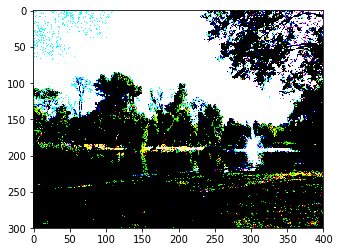

In [45]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Recall that `model` contains the pre-trained weights from the VGG-network (since we reset the graph we have to redefine the graph again in TensorFlow). And also recall that we need a particular layer to calculate the content cost: we will choose `conv4_2` from the graph. TensorFlow will then do the following:
1. Assign the content image to be the input to the VGG model.
2. Set $a_C$ to be the tensor giving the hidden layer activation for layer `conv4_2`.
3. Set $a_G$ to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using $a_C$ and $a_G$.

In [46]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

J_content = compute_content_cost(a_C, a_G)

In [47]:
# Similarly, we calculate the style cost and total cost.
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

J = total_cost(J_content, J_style, alpha = 10, beta = 40)

Finally, we need an optimizer in order to optimize the cost function $J$. The Adam optimizer, see the [documentation](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer), is a pretty good one so we take it.

In [48]:
optimizer = tf.train.AdamOptimizer(1.0)

train_step = optimizer.minimize(J)

The function below initializes the TensorFlow graph, assigns the input image and runs the `train_step` a large number of times.

In [60]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Ok, we have everything to generate a picture of the Oosterpark in Van Gogh style! It takes approximately 3 minutes per 20 iterations on my CPU, so you can take a brake while your computer creates some art. Note that we don't need that many iterations (n=60) in this example to generate already a nice picture. For other pictures and/or styles you might need more.

In [61]:
model_nn(sess, generated_image, num_iterations = 100)

Iteration 0 :
total cost = 316570980.0
content cost = 7431.4517
style cost = 7912416.5
Iteration 20 :
total cost = 22780748.0
content cost = 10460.019
style cost = 566903.7
Iteration 40 :
total cost = 9335375.0
content cost = 11112.941
style cost = 230606.16
Iteration 60 :
total cost = 5438894.5
content cost = 11432.769
style cost = 133114.17
Iteration 80 :
total cost = 3903561.5
content cost = 11623.009
style cost = 94683.29


array([[[[ 36.480972  ,  35.972687  ,  41.615677  ],
         [ 27.478043  ,  50.272827  ,  66.701805  ],
         [  0.07466877,  32.612446  ,  16.437626  ],
         ...,
         [ 26.12616   ,  36.957546  ,  11.779266  ],
         [ 22.223633  ,  16.182034  ,  16.95092   ],
         [-11.795263  , -28.306011  , -13.522855  ]],

        [[ 26.061548  ,  52.599285  ,  38.00344   ],
         [ 37.673668  ,  33.522278  ,  46.9899    ],
         [ -1.5128405 ,  18.524311  ,  17.48094   ],
         ...,
         [ 37.524044  ,  30.789846  ,  17.705925  ],
         [ 22.28464   ,  20.792233  ,  -9.339659  ],
         [ -1.7117819 , -19.83331   , -18.86745   ]],

        [[ -2.4026415 ,  43.6484    ,  21.445406  ],
         [ -0.17711154,  42.787415  ,  32.161224  ],
         [ -3.817091  ,  18.878218  ,  35.27064   ],
         ...,
         [ 14.668822  ,  -7.5061593 ,  30.246746  ],
         [ 16.071796  ,  15.059096  ,  19.568316  ],
         [ 21.157976  ,  35.677723  ,  35.630642  ]],

## To do
Creating a picture of my daughter Picasso style. Or something, e.g a bird, in Kandinsky style (my favourite painter)